
# Mortal Kombat Review Sentiment Analysis Project

In [2]:
!pip install sastrawi
!pip install gensim
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but yo

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import nltk
import warnings
import requests
import csv
from io import StringIO

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load review data

In [2]:
# Assuming file path would be provided as per your environment
df_reviews = pd.read_csv("app_reviews.csv")

# Display basic information about the dataset
print(f"Total reviews collected: {df_reviews.shape[0]}")
print(f"Total columns in the data: {df_reviews.shape[1]}")
print("\nFirst 5 rows of the dataset:")
print(df_reviews.head())

Total reviews collected: 43854
Total columns in the data: 11

First 5 rows of the dataset:
                               reviewId         userName  \
0  96ed75b0-0e90-42fa-852a-1b64c0fe7d7f  Pengguna Google   
1  8d535b4d-b590-4360-9019-b991a9bcf6cf  Pengguna Google   
2  a79b4e71-e692-4476-a923-7167636c8d55  Pengguna Google   
3  4dfdef59-8c18-4e30-be66-883c2108dbd9  Pengguna Google   
4  f616179f-c310-43cd-b13d-061c86402d90  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Dalam pertempuran masih ada delay, event nya b...      4              4   
1  selamat siang developer mortal kombat mobile d...   

In [3]:
# Check for missing values
print("\nMissing values in each column:")
print(df_reviews.isnull().sum())


Missing values in each column:
reviewId                    0
userName                    0
userImage                   0
content                    11
score                       0
thumbsUpCount               0
reviewCreatedVersion    28420
at                          0
replyContent            43299
repliedAt               43299
appVersion              28420
dtype: int64


In [4]:
# Information about the dataset structure
print("\nDataset information:")
df_reviews.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43854 entries, 0 to 43853
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              43854 non-null  object
 1   userName              43854 non-null  object
 2   userImage             43854 non-null  object
 3   content               43843 non-null  object
 4   score                 43854 non-null  int64 
 5   thumbsUpCount         43854 non-null  int64 
 6   reviewCreatedVersion  15434 non-null  object
 7   at                    43854 non-null  object
 8   replyContent          555 non-null    object
 9   repliedAt             555 non-null    object
 10  appVersion            15434 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.7+ MB


In [5]:
# Check for duplicates
duplicates = df_reviews.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


# Data Cleaning - Remove unnecessary columns

In [6]:
# Adjust this based on your actual dataset columns
columns_to_drop = ['replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion']
# Check if columns exist before dropping
columns_to_drop = [col for col in columns_to_drop if col in df_reviews.columns]
df_clean = df_reviews.drop(columns=columns_to_drop, errors='ignore')

print("\nColumns after cleanup:")
print(df_clean.columns)


Columns after cleanup:
Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'at'],
      dtype='object')


In [7]:
# Check text length statistics
if 'content' in df_clean.columns:
    text_lengths = df_clean['content'].apply(lambda x: len(str(x)))
    print("\nText length statistics:")
    print(text_lengths.describe())


Text length statistics:
count    43854.000000
mean        48.305719
std         64.054909
min          1.000000
25%         11.000000
50%         27.000000
75%         61.000000
max       3208.000000
Name: content, dtype: float64


# Text Preprocessing Functions

In [8]:
# Text Preprocessing Functions
def clean_text(text):
    """Remove special characters, links, mentions, etc."""
    text = str(text)  # Ensure text is string
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]', '', text)  # Remove RT
    text = re.sub(r"http\S+", '', text)  # Remove links
    text = re.sub(r'[0-9]+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.replace('\n', ' ')  # Replace newlines
    text = text.strip()  # Remove leading/trailing whitespace
    return text

def case_folding(text):
    """Convert text to lowercase"""
    return text.lower()

def tokenize_text(text):
    """Split text into tokens"""
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Remove stopwords from tokens"""
    # Combine Indonesian and English stopwords
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

    # Add custom stopwords for gaming app reviews
    custom_stopwords = {
        'game', 'aplikasi', 'app', 'main', 'download', 'install',
        'update', 'ya', 'iya', 'gak', 'ga', 'nya', 'sih', 'ku', 'di',
        'ke', 'yg', 'nih', 'si', 'deh', 'tuh', 'sih', 'kek'
    }
    stop_words.update(custom_stopwords)

    return [word for word in tokens if word not in stop_words]

def stemming_text(text):
    """Apply stemming to text"""
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

def tokens_to_text(tokens):
    """Join tokens back into text"""
    return ' '.join(tokens)

# Define slang word dictionaries

In [9]:
# Gaming-specific slang words for Mortal Kombat reviews
general_slang = {
    "yg": "yang", "dgn": "dengan", "dr": "dari", "utk": "untuk", "tp": "tapi",
    "krn": "karena", "jd": "jadi", "sdh": "sudah", "udh": "sudah", "aja": "saja",
    "blm": "belum", "msh": "masih", "lg": "lagi", "pd": "pada", "dlm": "dalam",
    "spy": "supaya", "skrg": "sekarang", "sm": "sama", "klo": "kalau", "kl": "kalau",
    "gw": "saya", "aq": "saya", "q": "saya", "sy": "saya", "lu": "kamu",
    "km": "kamu", "lo": "kamu", "u": "kamu", "gk": "tidak", "ga": "tidak",
    "ngga": "tidak", "gak": "tidak", "g": "tidak", "tdk": "tidak",
    "bwt": "buat", "trs": "terus", "ni": "ini", "tu": "itu"
}

gaming_slang = {
    "op": "overpowered", "buff": "penguatan", "nerf": "pelemahan",
    "char": "karakter", "chars": "karakter", "char2": "karakter-karakter",
    "fatality": "jurus pamungkas", "gameplay": "pengalaman bermain",
    "graphics": "grafik", "lag": "tersendat", "bug": "kesalahan",
    "dlc": "konten tambahan", "cheater": "penipu", "cheat": "curang",
    "matchmaking": "pencocokan", "noob": "pemula", "pro": "profesional",
    "skin": "tampilan", "skins": "tampilan", "update": "pembaruan",
    "grinding": "bermain terus-menerus", "graphics": "grafis",
    "boss": "lawan kuat", "combo": "kombinasi pukulan"
}

positive_slang = {
    "bgt": "banget", "bngt": "banget", "bgd": "banget",
    "mantap": "bagus", "mntap": "bagus", "mantul": "bagus",
    "keren": "bagus", "bgs": "bagus", "kece": "bagus", "jos": "bagus",
    "gampil": "mudah", "gampang": "mudah", "oke": "bagus", "oce": "bagus",
    "asik": "menyenangkan", "rekomen": "rekomendasi", "juara": "terbaik",
    "ajib": "bagus", "the best": "terbaik", "best": "terbaik",
    "wow": "mengesankan", "gokil": "luar biasa", "gila": "luar biasa",
    "smooth": "lancar", "suka": "menyukai", "enak": "nyaman",
    "ringan": "efisien", "cepet": "cepat", "worth": "bernilai"
}

negative_slang = {
    "jelek": "buruk", "parah": "buruk", "ancur": "rusak",
    "lemot": "lambat", "lelet": "lambat", "ngelag": "tersendat",
    "susah": "sulit", "ribet": "rumit", "error": "kesalahan",
    "eror": "kesalahan", "crash": "macet", "berat": "tidak ringan",
    "boros": "tidak hemat", "mahal": "tinggi harga", "kurang": "tidak cukup",
    "aneh": "tidak normal", "payah": "mengecewakan", "nyesel": "menyesal",
    "zonk": "mengecewakan", "ampas": "buruk", "sampah": "buruk",
    "burik": "jelek", "cacad": "cacat", "cacat": "rusak",
    "ngadat": "bermasalah", "ngaco": "kacau", "beban": "memberatkan",
    "gajelas": "tidak jelas", "ga mantap": "tidak bagus"
}

# Combine all slang dictionaries
all_slang = {}
all_slang.update(general_slang)
all_slang.update(gaming_slang)
all_slang.update(positive_slang)
all_slang.update(negative_slang)

def replace_slang(text):
    """Replace slang words with standard words"""
    words = text.split()
    result = []
    for word in words:
        if word in all_slang:
            result.append(all_slang[word])
        else:
            result.append(word)
    return ' '.join(result)

# Apply preprocessing to the dataset

In [11]:
# Make sure to use the correct column name
content_column = 'content' if 'content' in df_clean.columns else df_clean.columns[0]

import nltk
nltk.download('punkt_tab')


# 1. Text cleaning
df_clean['text_clean'] = df_clean[content_column].apply(clean_text)

# 2. Case folding
df_clean['text_lowercase'] = df_clean['text_clean'].apply(case_folding)

# 3. Replace slang words
df_clean['text_normalized'] = df_clean['text_lowercase'].apply(replace_slang)

# 4. Tokenization
df_clean['text_tokens'] = df_clean['text_normalized'].apply(tokenize_text)

# 5. Stopword removal
df_clean['text_without_stopwords'] = df_clean['text_tokens'].apply(remove_stopwords)

# 6. Convert tokens back to text
df_clean['processed_text'] = df_clean['text_without_stopwords'].apply(tokens_to_text)

# Display a sample of the processed text
print("\nSample of preprocessed text:")
print(df_clean[['text_clean', 'processed_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Sample of preprocessed text:
                                          text_clean  \
0  Dalam pertempuran masih ada delay event nya ba...   
1  selamat siang developer mortal kombat mobile d...   
2  gamenya bagus banget tapi tolong grafiknya tam...   
3  masuk game aja leg Jelek masuk game Super Supe...   
4  Niat hati mau kembali mainkan game ini setelah...   

                                      processed_text  
0  pertempuran delay event bagus tampilan segi ko...  
1  selamat siang developer mortal kombat mobile s...  
2  gamenya bagus banget tolong grafiknya tambahin...  
3  masuk leg buruk masuk super super lambat pokon...  
4  niat hati mainkan save data cloud akun wb play...  


# Sentiment Lexicon-based Approach

In [12]:
# Fetch lexicons
def fetch_lexicon(url):
    """Fetch sentiment lexicon from a URL"""
    response = requests.get(url)
    if response.status_code == 200:
        return {word: int(score) for word, score in csv.reader(StringIO(response.text), delimiter=',')}
    else:
        print(f"Failed to download lexicon from {url}")
        return {}

# Lexicon URLs - replace with your actual lexicon URLs
lexicon_positive_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_negative_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

lexicon_positive = fetch_lexicon(lexicon_positive_url)
lexicon_negative = fetch_lexicon(lexicon_negative_url)

# Alternative approach if URLs don't work - create simple lexicons
if not lexicon_positive or not lexicon_negative:
    print("Using fallback lexicons")

    # Simple positive lexicon with gaming terms
    lexicon_positive = {
        'bagus': 1, 'suka': 1, 'keren': 1, 'mantap': 1, 'mudah': 1,
        'lancar': 1, 'menyenangkan': 1, 'rekomendasi': 1, 'bermutu': 1,
        'terbaik': 1, 'mengesankan': 1, 'luar biasa': 1, 'cepat': 1,
        'bernilai': 1, 'bermanfaat': 1, 'ramah': 1, 'worth': 1,
        'sempurna': 1, 'juara': 1, 'epic': 1, 'awesome': 1, 'amazing': 1,
        'fantastis': 1, 'memuaskan': 1, 'menarik': 1, 'responsif': 1,
        'stabil': 1, 'adil': 1, 'balance': 1, 'fair': 1, 'hiburan': 1,
        'pro': 1, 'fun': 1, 'asik': 1
    }

    # Simple negative lexicon with gaming terms
    lexicon_negative = {
        'buruk': -1, 'jelek': -1, 'rusak': -1, 'lambat': -1, 'tersendat': -1,
        'sulit': -1, 'rumit': -1, 'kesalahan': -1, 'macet': -1, 'berat': -1,
        'mahal': -1, 'aneh': -1, 'mengecewakan': -1, 'menyesal': -1, 'kecewa': -1,
        'payah': -1, 'tidak berguna': -1, 'cacat': -1, 'bermasalah': -1,
        'kacau': -1, 'memberatkan': -1, 'tidak jelas': -1, 'penipuan': -1,
        'cheat': -1, 'unfair': -1, 'overpowered': -1, 'lagg': -1, 'lag': -1,
        'crash': -1, 'bug': -1, 'glitch': -1, 'curang': -1, 'overpriced': -1,
        'hackers': -1, 'bosan': -1, 'monoton': -1, 'repetitif': -1
    }

def analyze_sentiment(tokens):
    """Analyze sentiment using lexicons"""
    score = 0

    for word in tokens:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        return score, 'positive'
    elif score < 0:
        return score, 'negative'
    else:
        return score, 'neutral'

# Apply sentiment analysis
results = df_clean['text_without_stopwords'].apply(analyze_sentiment)
results = list(zip(*results))
df_clean['sentiment_score'] = results[0]
df_clean['sentiment'] = results[1]

# Count sentiment distribution
sentiment_counts = df_clean['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)


Sentiment distribution:
sentiment
positive    24693
neutral     11856
negative     7305
Name: count, dtype: int64


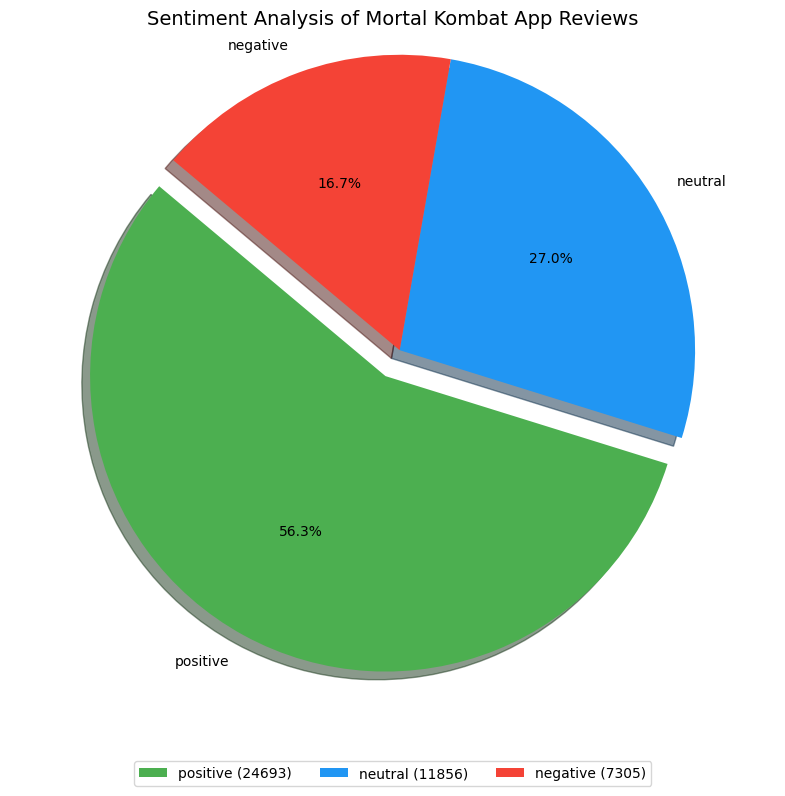

In [13]:
# Visualization - Pie Chart
plt.figure(figsize=(8, 8))
colors = ['#4CAF50', '#2196F3', '#F44336']
explode = [0.1, 0, 0]
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    explode=explode,
    shadow=True
)
plt.title('Sentiment Analysis of Mortal Kombat App Reviews', fontsize=14)
plt.axis('equal')
plt.legend(
    labels=[f'{label} ({count})' for label, count in zip(sentiment_counts.index, sentiment_counts)],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3
)
plt.tight_layout()
plt.show()

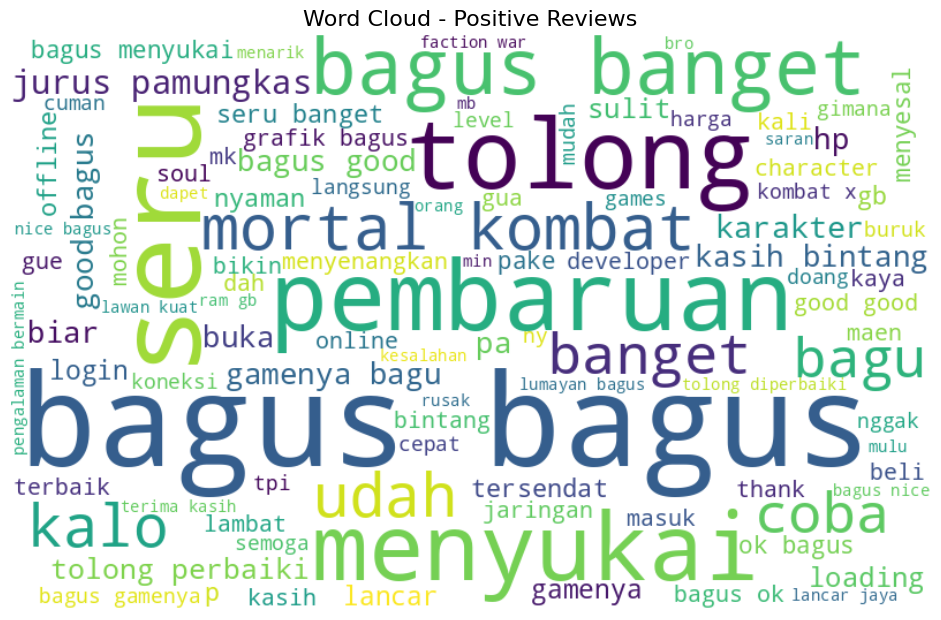

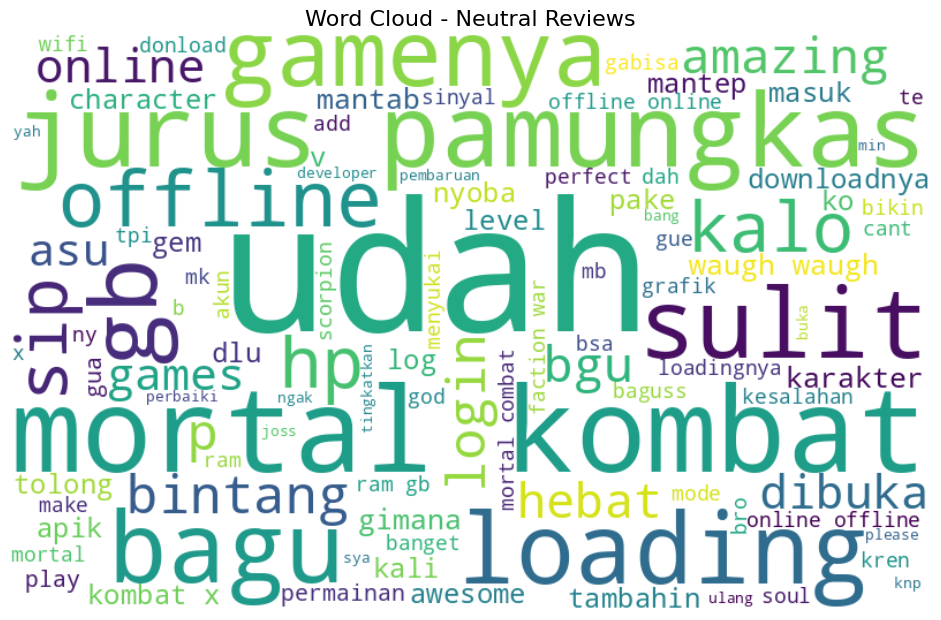

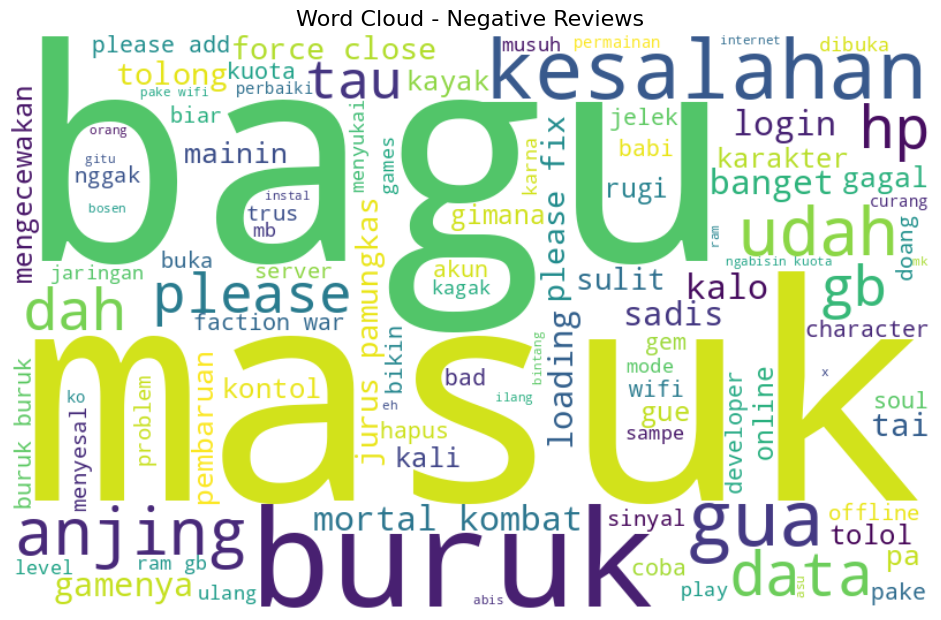

In [15]:
# Separate data by sentiment
positive_reviews = df_clean[df_clean['sentiment'] == 'positive'].reset_index(drop=True)
neutral_reviews = df_clean[df_clean['sentiment'] == 'neutral'].reset_index(drop=True)
negative_reviews = df_clean[df_clean['sentiment'] == 'negative'].reset_index(drop=True)

# Word Clouds for each sentiment class
def generate_wordcloud(reviews, title):
    """Generate word cloud from reviews"""
    text = ' '.join([' '.join(tokens) for tokens in reviews['text_without_stopwords']])
    wordcloud = WordCloud(width=800, height=500, background_color='white',
                          min_font_size=10, max_words=100).generate(text)

    plt.figure(figsize=(10, 6))
    plt.title(f'Word Cloud - {title}', fontsize=16)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Generate word clouds
if not positive_reviews.empty:
    generate_wordcloud(positive_reviews, 'Positive Reviews')

if not neutral_reviews.empty:
    generate_wordcloud(neutral_reviews, 'Neutral Reviews')

if not negative_reviews.empty:
    generate_wordcloud(negative_reviews, 'Negative Reviews')

# Additional visualizations

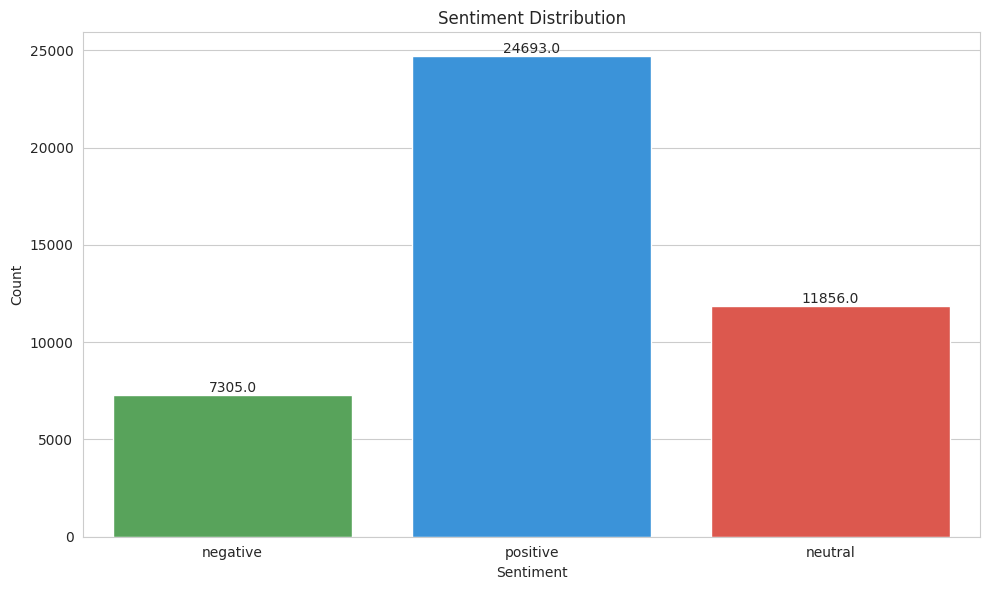

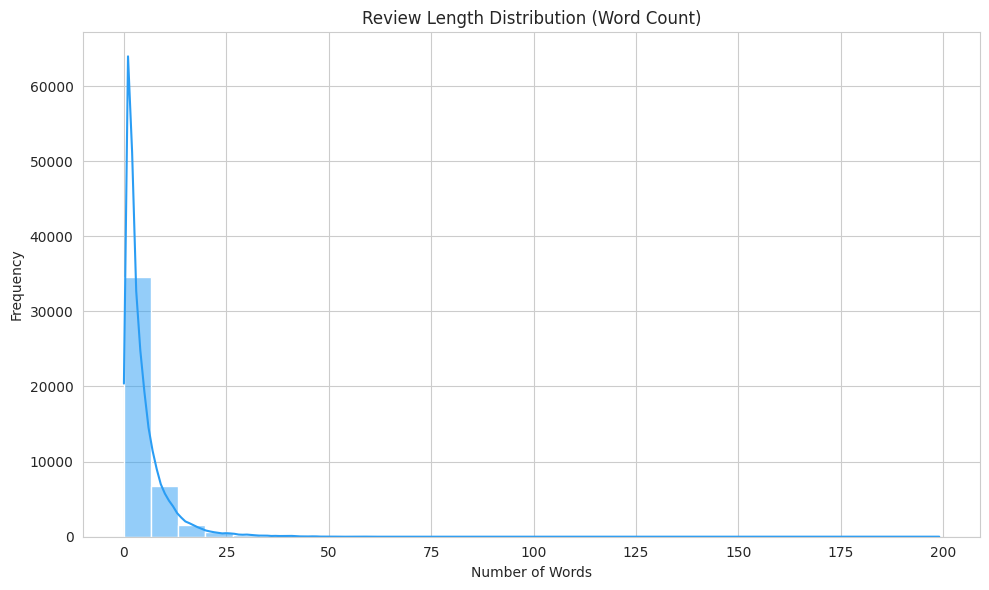

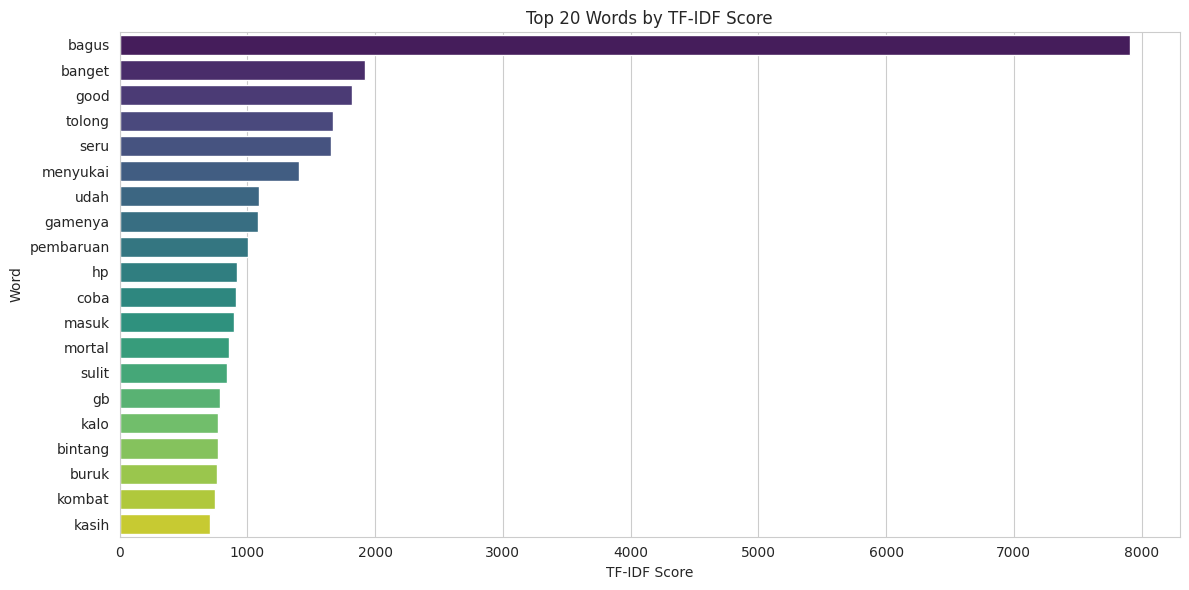

In [16]:
# Bar chart of sentiment distribution
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
ax = sns.countplot(x='sentiment', data=df_clean, palette=['#4CAF50', '#2196F3', '#F44336'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# Text length distribution
df_clean['text_length'] = df_clean['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['text_length'], bins=30, kde=True, color='#2a9df4')
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Most frequent words using TF-IDF
vectorizer = TfidfVectorizer(max_features=20)
X = vectorizer.fit_transform(df_clean['processed_text'])
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = X.sum(axis=0).tolist()[0]

# Create dataframe of features and scores
tfidf_df = pd.DataFrame({
    'word': feature_names,
    'score': tfidf_scores
}).sort_values('score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='score', y='word', data=tfidf_df, palette='viridis')
plt.title('Top 20 Words by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

# Machine Learning Models and Evaluation

In [17]:
# Prepare data for modeling
X = df_clean['processed_text']
y = df_clean['sentiment']

In [18]:
# 1. SVM with TF-IDF (80/20 split)
print("\n\n----- MODEL 1: SVM with TF-IDF (80/20 split) -----")
vectorizer_svm = TfidfVectorizer()
X_svm = vectorizer_svm.fit_transform(X)

# Split data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y, test_size=0.2, random_state=42, stratify=y
)

# Train SVM model
svm_model = LinearSVC()
svm_model.fit(X_train_svm, y_train_svm)

# Evaluate
y_pred_svm_train = svm_model.predict(X_train_svm)
y_pred_svm_test = svm_model.predict(X_test_svm)

svm_train_acc = accuracy_score(y_train_svm, y_pred_svm_train)
svm_test_acc = accuracy_score(y_test_svm, y_pred_svm_test)

print(f"SVM Training Accuracy: {svm_train_acc:.2%}")
print(f"SVM Testing Accuracy: {svm_test_acc:.2%}")
print("\nClassification Report (SVM):")
print(classification_report(y_test_svm, y_pred_svm_test))



----- MODEL 1: SVM with TF-IDF (80/20 split) -----
SVM Training Accuracy: 98.89%
SVM Testing Accuracy: 93.63%

Classification Report (SVM):
              precision    recall  f1-score   support

    negative       0.92      0.85      0.89      1461
     neutral       0.88      0.93      0.91      2371
    positive       0.97      0.97      0.97      4939

    accuracy                           0.94      8771
   macro avg       0.92      0.91      0.92      8771
weighted avg       0.94      0.94      0.94      8771



In [19]:
# 2. Random Forest with CountVectorizer (70/30 split)
print("\n\n----- MODEL 2: Random Forest with CountVectorizer (70/30 split) -----")
count_vectorizer = CountVectorizer()
X_rf = count_vectorizer.fit_transform(X)

# Split data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y, test_size=0.3, random_state=42, stratify=y
)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluate
y_pred_rf_train = rf_model.predict(X_train_rf)
y_pred_rf_test = rf_model.predict(X_test_rf)

rf_train_acc = accuracy_score(y_train_rf, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test_rf, y_pred_rf_test)

print(f"Random Forest Training Accuracy: {rf_train_acc:.2%}")
print(f"Random Forest Testing Accuracy: {rf_test_acc:.2%}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test_rf, y_pred_rf_test))



----- MODEL 2: Random Forest with CountVectorizer (70/30 split) -----
Random Forest Training Accuracy: 100.00%
Random Forest Testing Accuracy: 91.48%

Classification Report (Random Forest):
              precision    recall  f1-score   support

    negative       0.89      0.75      0.82      2192
     neutral       0.89      0.93      0.91      3557
    positive       0.93      0.95      0.94      7408

    accuracy                           0.91     13157
   macro avg       0.91      0.88      0.89     13157
weighted avg       0.91      0.91      0.91     13157



In [20]:
# 3. Deep Learning Model with TF-IDF (80/20 split)
print("\n\n----- MODEL 3: Deep Learning with TF-IDF (80/20 split) -----")
vectorizer_dl = TfidfVectorizer(max_features=5000)
X_dl = vectorizer_dl.fit_transform(X).toarray()

# Split data
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y, test_size=0.2, random_state=42, stratify=y
)

# Convert labels to numeric format
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_dl_encoded = le.fit_transform(y_train_dl)
y_test_dl_encoded = le.transform(y_test_dl)

# Build deep learning model
model_dl = Sequential([
    Dense(512, input_shape=(X_dl.shape[1],), activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

# Compile model
model_dl.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    min_delta=0.01
)

# Train model
history = model_dl.fit(
    X_train_dl, y_train_dl_encoded,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_dl, y_test_dl_encoded),
    verbose=1,
    callbacks=[early_stopping]
)



----- MODEL 3: Deep Learning with TF-IDF (80/20 split) -----
Epoch 1/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.7860 - loss: 0.4968 - val_accuracy: 0.9298 - val_loss: 0.2070
Epoch 2/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 86s 42ms/step - accuracy: 0.9598 - loss: 0.1253 - val_accuracy: 0.9302 - val_loss: 0.2171
Epoch 3/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9762 - loss: 0.0796 - val_accuracy: 0.9341 - val_loss: 0.2422
Epoch 4/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - accuracy: 0.9840 - loss: 0.0572 - val_accuracy: 0.9233 - val_loss: 0.2489
Epoch 5/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.9867 - loss: 0.0508 - val_accuracy: 0.9265 - val_loss: 0.2730
Epoch 6/50
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - accuracy: 0.9911 - loss: 0.0375 - val_accuracy: 0.9293 - val_loss: 0.2937


In [21]:
# Evaluate
dl_train_loss, dl_train_acc = model_dl.evaluate(X_train_dl, y_train_dl_encoded, verbose=0)
dl_test_loss, dl_test_acc = model_dl.evaluate(X_test_dl, y_test_dl_encoded, verbose=0)

print(f"Deep Learning Training Accuracy: {dl_train_acc:.2%}")
print(f"Deep Learning Testing Accuracy: {dl_test_acc:.2%}")

# Get predictions
y_pred_dl = model_dl.predict(X_test_dl)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)
y_pred_dl_labels = le.inverse_transform(y_pred_dl_classes)

print("\nClassification Report (Deep Learning):")
print(classification_report(y_test_dl, y_pred_dl_labels))

Deep Learning Training Accuracy: 96.49%
Deep Learning Testing Accuracy: 92.98%
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Classification Report (Deep Learning):
              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      1461
     neutral       0.91      0.90      0.90      2371
    positive       0.95      0.97      0.96      4939

    accuracy                           0.93      8771
   macro avg       0.92      0.91      0.91      8771
weighted avg       0.93      0.93      0.93      8771



In [22]:
# Compare model performance
models = {
    'SVM (TF-IDF, 80/20)': [svm_train_acc, svm_test_acc],
    'Random Forest (Count, 70/30)': [rf_train_acc, rf_test_acc],
    'Deep Learning (TF-IDF, 80/20)': [dl_train_acc, dl_test_acc]
}

comparison_df = pd.DataFrame(models, index=['Training Accuracy', 'Testing Accuracy']).T
comparison_df = comparison_df.sort_values('Testing Accuracy', ascending=False)

print("\n\n----- MODEL COMPARISON -----")
print(comparison_df)



----- MODEL COMPARISON -----
                               Training Accuracy  Testing Accuracy
SVM (TF-IDF, 80/20)                     0.988884          0.936267
Deep Learning (TF-IDF, 80/20)           0.964912          0.929769
Random Forest (Count, 70/30)            0.999967          0.914798


<Figure size 1200x600 with 0 Axes>

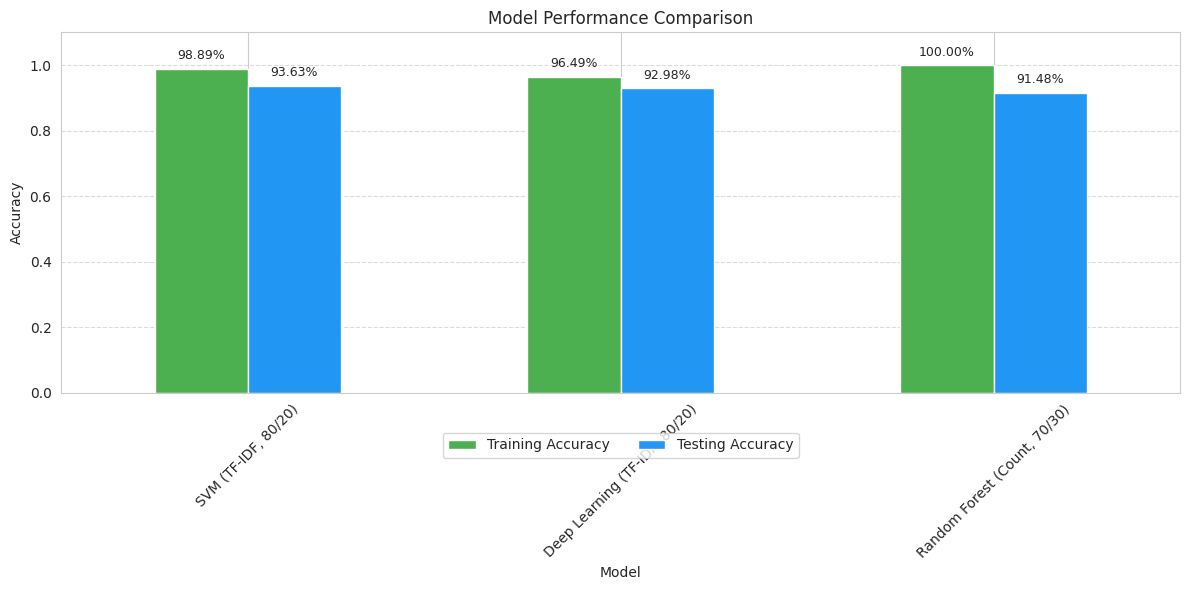

In [23]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
comparison_df.plot(kind='bar', figsize=(12, 6), color=['#4CAF50', '#2196F3'])
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)

# Add value labels
for i, model in enumerate(comparison_df.index):
    for j, metric in enumerate(['Training Accuracy', 'Testing Accuracy']):
        plt.text(i + (j - 0.5) * 0.25, comparison_df.loc[model, metric] + 0.02,
                 f'{comparison_df.loc[model, metric]:.2%}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

In [24]:
# Inference function for new reviews using in-memory models
def predict_sentiment(review_text, model_name='svm'):
    """
    Predict sentiment for a new review using in-memory models

    Parameters:
    review_text (str): The text of the new review
    model_name (str): Model to use ('svm', 'rf', or 'dl')

    Returns:
    str: Predicted sentiment ('positive', 'negative', or 'neutral')
    """
    # Preprocess the text
    cleaned = clean_text(review_text)
    lowercased = case_folding(cleaned)
    normalized = replace_slang(lowercased)
    tokens = tokenize_text(normalized)
    without_stopwords = remove_stopwords(tokens)
    processed = tokens_to_text(without_stopwords)

    # Choose the model - all models are already in memory
    if model_name == 'svm':
        # Use the SVM model that's already trained
        X = vectorizer_svm.transform([processed])
        return svm_model.predict(X)[0]

    elif model_name == 'rf':
        # Use the Random Forest model that's already trained
        X = count_vectorizer.transform([processed])
        return rf_model.predict(X)[0]

    elif model_name == 'dl':
        # Use the Deep Learning model that's already trained
        X = vectorizer_dl.transform([processed]).toarray()
        prediction = model_dl.predict(X)
        predicted_class = np.argmax(prediction, axis=1)
        return le.inverse_transform(predicted_class)[0]

    else:
        raise ValueError("Model must be 'svm', 'rf', or 'dl'")

In [28]:
# Interactive input for sentiment prediction
def interactive_prediction():
    """Interactive function to predict sentiment of user input"""
    print("\n\n----- INTERACTIVE SENTIMENT PREDICTION -----")
    print("Enter a review about Mortal Kombat to analyze its sentiment (or 'exit' to quit):")

    while True:
        user_input = input("\nEnter your review: ")

        if user_input.lower() == 'exit':
            print("Exiting sentiment analysis tool.")
            break

        # Get predictions from all models
        svm_prediction = predict_sentiment(user_input, 'svm')
        rf_prediction = predict_sentiment(user_input, 'rf')
        dl_prediction = predict_sentiment(user_input, 'dl')

        # Determine the final prediction (majority vote)
        predictions = [svm_prediction, rf_prediction, dl_prediction]
        final_prediction = max(set(predictions), key=predictions.count)

        # Print results
        print(f"\nSVM prediction: {svm_prediction}")
        print(f"Random Forest prediction: {rf_prediction}")
        print(f"Deep Learning prediction: {dl_prediction}")
        print(f"Final prediction (majority vote): {final_prediction}")

        # Display prediction with emojis
        emoji_dict = {
            'positive': '😊 POSITIVE',
            'neutral': '😐 NEUTRAL',
            'negative': '😞 NEGATIVE'
        }

        print(f"\nSentiment: {emoji_dict.get(final_prediction, final_prediction)}")

In [29]:
interactive_prediction()



----- INTERACTIVE SENTIMENT PREDICTION -----
Enter a review about Mortal Kombat to analyze its sentiment (or 'exit' to quit):

Enter your review: aplikasi ini sangat bagus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

SVM prediction: positive
Random Forest prediction: positive
Deep Learning prediction: positive
Final prediction (majority vote): positive

Sentiment: 😊 POSITIVE

Enter your review: aplikasi ini jelek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

SVM prediction: negative
Random Forest prediction: negative
Deep Learning prediction: negative
Final prediction (majority vote): negative

Sentiment: 😞 NEGATIVE

Enter your review: quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

SVM prediction: neutral
Random Forest prediction: neutral
Deep Learning prediction: neutral
Final prediction (majority vote): neutral

Sentiment: 😐 NEUTRAL

Enter your review: exit
Exiting sentiment analysis tool.
